<a href="https://colab.research.google.com/github/mostafa-ja/Machine-Learning-fall2023/blob/main/ML_presentation4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Load Dataset

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 116078798.90it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 25022865.90it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26771019.79it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6794054.48it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [4]:
print(len(mnist_train))
print(len(mnist_test))

60000
10000


#Model Architecture and Training

In [7]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

torch.manual_seed(42)

In [17]:
def epoch(loader, model, opt=None):
    total_loss, accuracy = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        accuracy += (yp.max(dim=1)[1] == y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return accuracy / len(loader.dataset), total_loss / len(loader.dataset)

In [20]:
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
print('train_accuracy\ttrain_loss\ttest_accuracy\ttest_loss')

for t in range(10):
    train_acc, train_loss = epoch(train_loader, model_cnn, opt)
    test_acc, test_loss = epoch(test_loader, model_cnn)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_acc, train_loss, test_acc, test_loss)), sep="\t")

train_accuracy	train_loss	test_accuracy	test_loss
0.811750	0.564568	0.972300	0.089879
0.975017	0.081948	0.983200	0.056712
0.983217	0.053643	0.982400	0.052372
0.987750	0.040253	0.983000	0.052993
0.989950	0.031349	0.983500	0.048609
0.995733	0.014417	0.988500	0.035479
0.996950	0.011108	0.988600	0.036312
0.997467	0.009860	0.988500	0.036657
0.997917	0.008890	0.988100	0.037115
0.998100	0.008041	0.988200	0.038043


In [23]:
# Function to calculate accuracy
def calculate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient tracking
        for inputs, labels in data_loader:
            inputs = inputs.to(device)  # Move inputs to GPU/CPU if available
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Assuming test_loader contains the test dataset
accuracy = calculate_accuracy(model_cnn, test_loader)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 98.82%


In [24]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

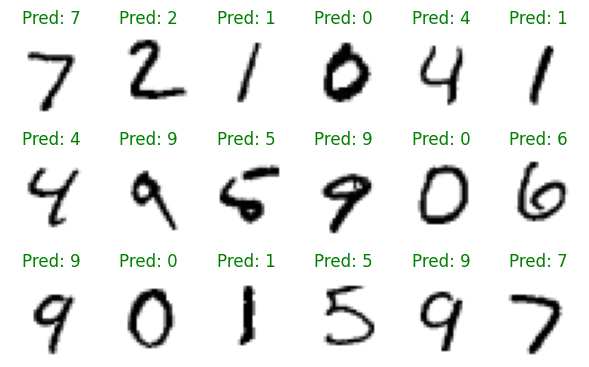

In [25]:
### Illustrate original predictions
yp = model_cnn(X)
plot_images(X, y, yp, 3, 6)

In [26]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [27]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_correct = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)

        total_correct += (yp.max(dim=1)[1] == y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_correct / len(loader.dataset), total_loss / len(loader.dataset)

In [28]:
print("Accuracy on FGSM adversarial attack:", epoch_adversarial(model_cnn, test_loader, fgsm, 0.1)[0])

Accuracy on FGSM adversarial attack: 0.5582


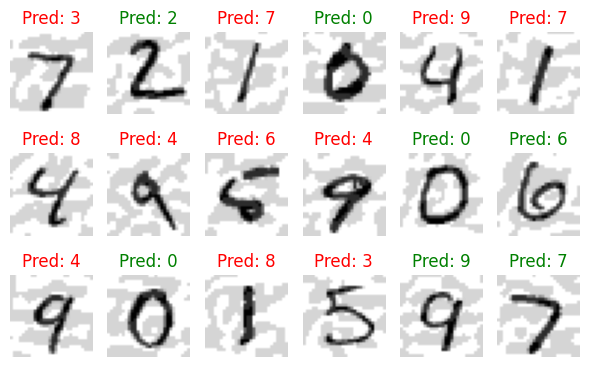

In [29]:
### Illustrate attacked images
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break
delta = fgsm(model_cnn, X, y, 0.1)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [32]:
def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [33]:
print("Accuracy on PGD adversarial attack:", epoch_adversarial(model_cnn, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])

Accuracy on PGD adversarial attack: 0.2933


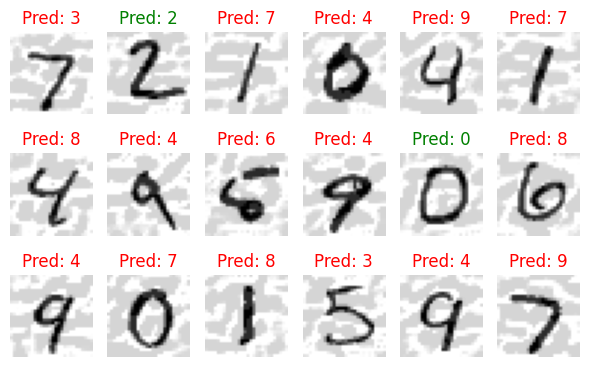

In [34]:
### Illustrate attacked images
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

delta = pgd_linf(model_cnn, X, y, epsilon=0.1, alpha=1e-2, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)


In [35]:
pgd_attack_range = np.arange(0.0, 0.52, 0.025)
pgd_acc = []
for eps in pgd_attack_range:
    pgd_acc.append(epoch_adversarial(model_cnn, test_loader, pgd_linf, eps, 1e-2, 40)[0])

In [ ]:
iter_fgsm_attack_range = np.arange(0.0, 0.52, 0.025)
iter_fgsm_acc = []
for eps in iter_fgsm_attack_range:
    iter_fgsm_acc.append(epoch_adversarial(model_cnn, test_loader, fgsm, eps)[0])

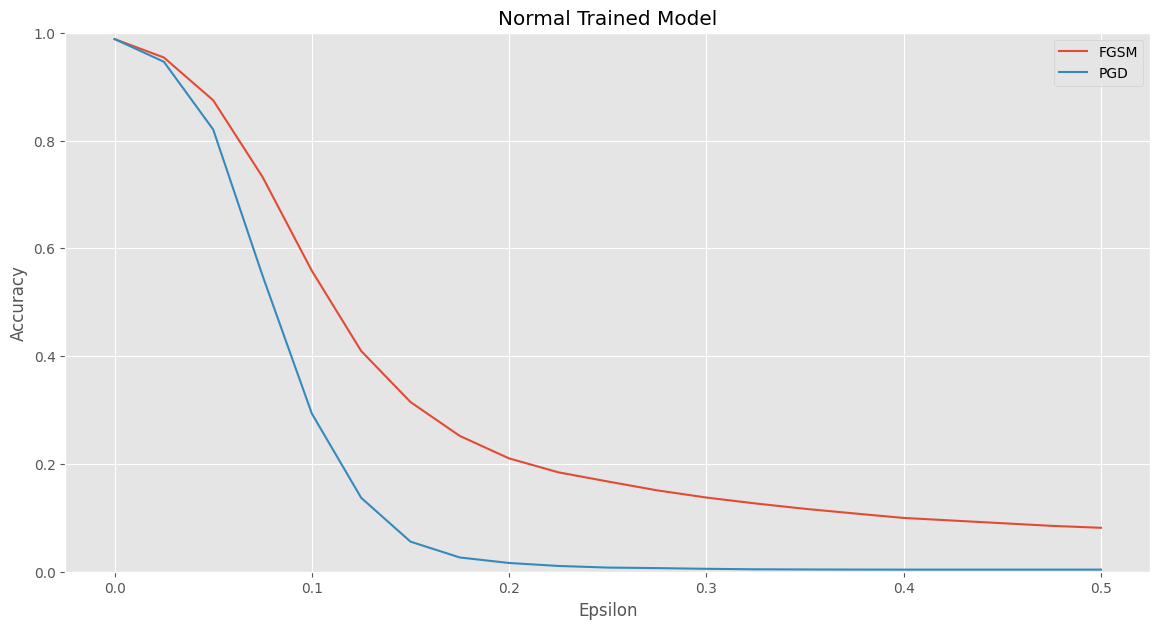

In [43]:
import matplotlib.pyplot as plt

with plt.style.context('ggplot'):
    plt.figure(figsize=(14, 7))
    plt.title('Normal Trained Model')  # Corrected 'set_title' to 'title'
    plt.plot(iter_fgsm_attack_range, iter_fgsm_acc, label='FGSM')
    plt.plot(pgd_attack_range, pgd_acc, label='PGD')
    plt.xlabel('Epsilon')  # Corrected 'set_xlabel' to 'xlabel'
    plt.ylabel('Accuracy')  # Added ylabel for clarity
    plt.ylim((0, 1))
    plt.legend()  # Added legend for the plotted lines

    plt.show()


#Adversarial training with adversarial examples

In [18]:
def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_correct = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_correct += (yp.max(dim=1)[1] == y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_correct / len(loader.dataset), total_loss / len(loader.dataset)

In [19]:
model_cnn_robust = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                                 nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                                 nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                                 Flatten(),
                                 nn.Linear(7*7*64, 100), nn.ReLU(),
                                 nn.Linear(100, 10)).to(device)

In [20]:
def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=20):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)

    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [ ]:
opt = optim.SGD(model_cnn_robust.parameters(), lr=1e-1)

print('train_accuracy\ttest_accuracy\tadv_accuracy')

for t in range(10):
    train_accuracy, train_loss = epoch_adversarial(train_loader, model_cnn_robust, pgd_linf, opt)
    test_accuracy, test_loss = epoch(test_loader, model_cnn_robust)
    adv_accuracy, adv_loss = epoch_adversarial(test_loader, model_cnn_robust, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_accuracy, test_accuracy, adv_accuracy)), sep="\t")
torch.save(model_cnn_robust.state_dict(), "model_cnn_robust.pt")

train_accuracy	test_accuracy	adv_accuracy
0.106750	0.113500	0.113500
0.716700	0.975300	0.932000
0.935350	0.982800	0.947800
0.954917	0.985000	0.957900
0.965050	0.986600	0.964900


In [ ]:
# Assuming test_loader contains the test dataset
accuracy = calculate_accuracy(model_cnn_robust, test_loader)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 99.07%


In [ ]:
# Assuming test_loader contains the test dataset
accuracy = epoch_adversarial(test_loader, model_cnn_robust, pgd_linf, num_iter=40)[0]
print(f"Accuracy on PGD attack: {accuracy * 100:.2f}%")

In [ ]:
pgd_acc_linf = []
for eps in pgd_attack_range:
    pgd_acc_linf.append(epoch_adversarial(model_cnn, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])

In [ ]:
iter_fgsm_acc_linf = []
for eps in iter_fgsm_attack_range:
    iter_fgsm_acc_linf.append(epoch_adversarial(model_cnn, test_loader, fgsm, eps)[0])

In [ ]:
with plt.style.context('ggplot'):

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    plt.figure(figsize=(14,7))

    axes[0].set_title('$L^2$-bounded adversary')
    axes[0].plot(pgd_attack_range, pgd_acc, label='Natural')
    axes[0].plot(pgd_attack_range, pgd_acc_linf, label='$L{\infty}$ training')
#     axes[0].vlines([3], 0, 1, colors=COLOURS[1], linestyle='--')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epsilon')
    axes[0].set_ylim((0,1))
    axes[0].legend()

    axes[1].set_title('$L^{\infty}$-bounded adversary')
    axes[1].plot(iter_fgsm_attack_range, iter_fgsm_acc)
    axes[1].plot(iter_fgsm_attack_range, iter_fgsm_acc_linf, label='$L{\infty}$ training')
#     axes[1].vlines([0.3], 0, 1, colors=COLOURS[2], linestyle='--')
    axes[1].set_xlabel('Epsilon')
    axes[1].set_ylim((0,1))

    plt.show()